In [111]:
from tsnecuda import TSNE
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.manifold import TSNE as sk_TSNE
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.decomposition import PCA

import torch
import os
from os.path import join
import regress

In [2]:
#load original dataset
ds = np.load('/data/Bernard/DARPA_data/pytorch_data_train.npy', allow_pickle=True)
data = ds[:,0]
label = ds[:,1]

In [3]:
#generate random noise
def gen_rand_noise(): # z
    noise = torch.randn(BATCH_SIZE, 128)
    return noise

In [46]:
#generate microstructures based on randomly generated design input
gen = torch.load('output/run_007_Jmodelbalancedsigmoid/generator.pt', map_location='cpu') 
gen.eval()

BATCH_SIZE = 1000
noise = gen_rand_noise()
low = 0.01
high  = 7
Js = []
J = np.random.uniform(low = low, high = high, size = BATCH_SIZE)
#J = np.ones(shape=BATCH_SIZE)*12
Js.append(J)

Js = np.expand_dims(np.ndarray.flatten(np.asarray(Js)), axis=1)
Js = torch.FloatTensor(Js)
print(Js.shape)

gen_img = gen(noise, Js).detach().numpy()

torch.Size([1000, 1])


/home/microway/.conda/envs/SGAN/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [47]:
#combine true and generated dataset for visualization
print(data.shape)
print(gen_img.shape)

x1 = []
y1 = []
for i in range(len(data)):
    img = np.reshape(data[i], (128*128))
    x1.append(img)
    y1.append(0.0)
true_data = np.asarray(x1)
y1 = np.asarray(y1)

x2 = []
y2 = []
for i in range(gen_img.shape[0]):
    img = np.reshape(gen_img[i][0], (128*128))
    x2.append(img)
    y2.append(1.0)
gen_data = np.asarray(x2)
y2 = np.asarray(y2)

print(true_data.shape)
print(gen_data.shape)

data = np.vstack((true_data, gen_data))
labels = np.concatenate((y1,y2))

print(data.shape)
print(labels.shape)

(54160, 16384)
(1000, 1, 128, 128)
(54160, 16384)
(1000, 16384)
(55160, 16384)
(55160,)


In [48]:
# run PCA on combined dataset to extract 80 features
def run_PCA(data):
    x = []
    for i in range(len(data)):
        img = np.reshape(data[i], (128*128))
        x.append(img)
    
    data = np.asarray(x)
    print(data.shape)

    #find top ten PC
    pca = PCA(n_components=80)

    #find test dataset coordinates in PC space
    pca_result = pca.fit_transform(data)
    print('PCA done')
    print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))
    print ('Variance explained by 80 PC:', np.sum(pca.explained_variance_ratio_))
    return pca_result

In [49]:
def plot_PCA(pca_result):
    save_dir = 'tsne_results/'
    pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3'])
    pca_df['pca1'] = pca_result[:,0]
    pca_df['pca2'] = pca_result[:,1]
    pca_df['pca3'] = pca_result[:,2]

    top_two_comp = pca_df[['pca1','pca2','pca3']] # taking first and second principal component
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(20, 12)
    
    #plot PC 1 vs PC 2
    ax[0].scatter(top_two_comp.values[:, 0], top_two_comp.values[:, 1], alpha=0.5, edgecolor='none')
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].axis('tight')
    #ax.legend()
    #ax[0].xlabel('Principal Component 1', fontsize=14)
    #ax[0].ylabel('Principal Component 2', fontsize=14)
    fig.savefig(save_dir + 'pca_12_unc.jpg',dpi=300)

    
    #plot PC 2 and 3
    #fig, ax = plt.subplots()
    ax[1].scatter(top_two_comp.values[:, 1], top_two_comp.values[:, 2], alpha=0.5, edgecolor='none')
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].axis('tight')
    #ax.legend()
    #plt.xlabel('Principal Component 2', fontsize=14)
    #plt.ylabel('Principal Component 3', fontsize=14)
    fig.savefig(save_dir + 'pca_23_unc.jpg', dpi=300)

    
    #plot PC 1 and 3
    #fig, ax = plt.subplots()
    ax[2].scatter(top_two_comp.values[:, 0], top_two_comp.values[:, 2], alpha=0.5, edgecolor='none')
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    ax[2].axis('tight')
    #ax.legend()
    #plt.xlabel('Principal Component 1',fontsize=14)
    #plt.ylabel('Principal Component 3',fontsize=14)
    fig.savefig(save_dir + 'pca_13_unc.jpg',dpi=300)

In [50]:
pca_results = run_PCA(data)

(55160, 16384)
PCA done
Variance explained per principal component: [0.06010948 0.05450019 0.0466353  0.04254105 0.03889036 0.03327953
 0.03249242 0.03210268 0.03115877 0.02934494 0.02825458 0.0258343
 0.02561358 0.02342574 0.02295746 0.02142682 0.0201986  0.01874712
 0.01855255 0.01809125 0.01664402 0.01646355 0.01492448 0.01434181
 0.01281402 0.01260943 0.0111978  0.01094936 0.01058165 0.01026934
 0.00993066 0.00974618 0.0088753  0.00779138 0.00766786 0.00729081
 0.00674794 0.00671456 0.00653016 0.00606672 0.00592326 0.00574254
 0.00493486 0.00484583 0.0047263  0.00426808 0.00423165 0.00408118
 0.00363093 0.00357559 0.00345553 0.00336669 0.00324228 0.00288047
 0.00275878 0.00271952 0.00267158 0.00260868 0.00243372 0.00236962
 0.00219667 0.00208007 0.0019797  0.00196349 0.00188086 0.00186314
 0.00183388 0.00180123 0.00176644 0.00158388 0.00152605 0.00149809
 0.00142331 0.00132803 0.00128316 0.00122884 0.00115305 0.00112147
 0.0011034  0.00108789]
Variance explained by 50 PC: 0.9384834

<IPython.core.display.Javascript object>


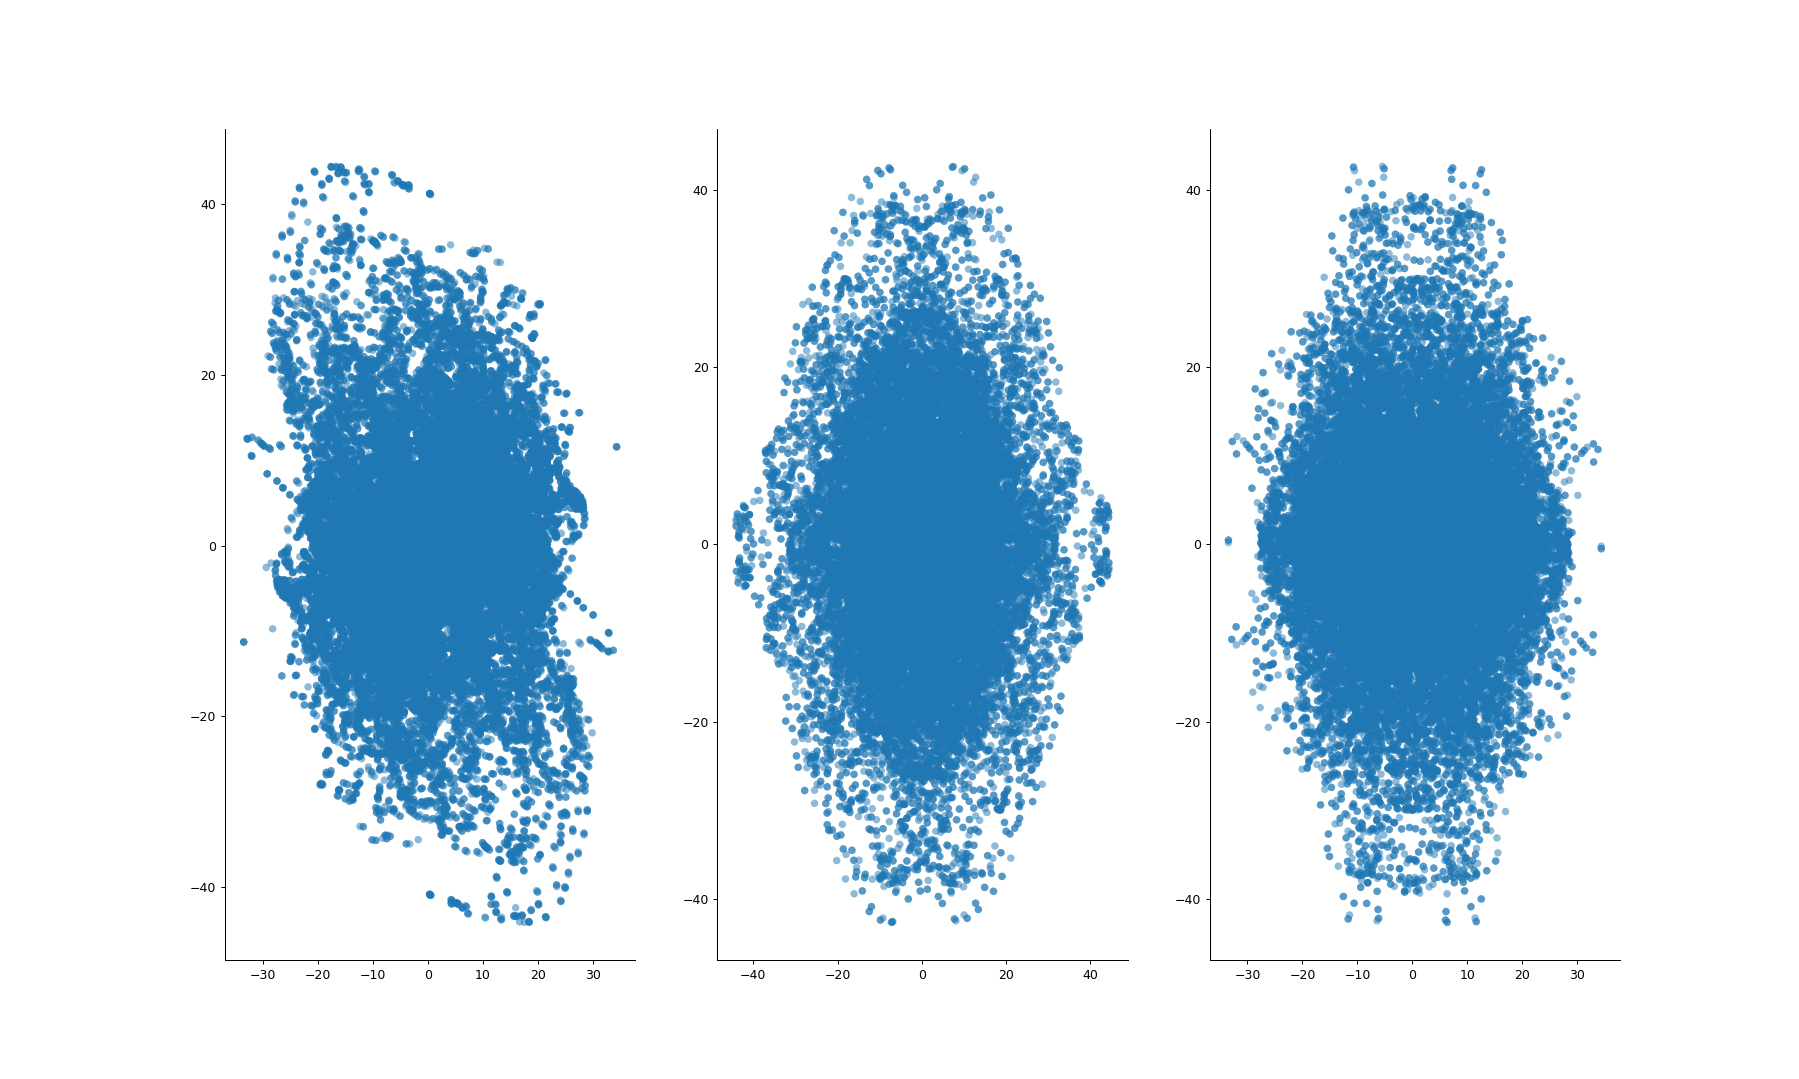

In [51]:
plot_PCA(pca_results)

In [58]:
#run TSNE on features extracted from PCA, GPU version currently limited to 2d
def run_gpu_tsne(data,label):
    
    x = []
    for i in range(len(data)):
        img = np.reshape(data[i], 80)
        x.append(img)
    
    data = np.asarray(x)
    print(data.shape)
    
    perplexity = [30]
    for i in range(len(perplexity)):
        print('Starting TSNE')
        nano_TSNE = TSNE(n_components=2, perplexity=perplexity[i], n_iter=10000, verbose=2).fit_transform(data)
    print('Done Cuda TSNE')
    return nano_TSNE

In [84]:
#run TSNE on features extracted from PCA, sklearn version can extend to 3d, but slower
def run_sk_tsne(data,label):
    x = []

    for i in range(len(data)):
        #img = np.reshape(data[i], (128*128))
        img = np.reshape(data[i], 80)
        x.append(img)
    
    data = np.asarray(x)
    print(data.shape)
    
    perplexity = [30]
    for i in range(len(perplexity)):
        print('Starting TSNE')
        nano_TSNE = sk_TSNE(n_components=3, perplexity=perplexity[i], n_iter=10000, verbose=2).fit_transform(data)
    print('Done SK TSNE')
    return nano_TSNE

In [73]:
def plot_tsne_2d(tsne_result,labels):
    save_dir = 'tsne_results/'
    df_subset = pd.DataFrame()
    df_subset['tsne-2d-one'] = tsne_result[:,0]
    df_subset['tsne-2d-two'] = tsne_result[:,1]

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    markers=['o','x']
    j = 0
    for y in np.unique(labels):
        marker = markers[j]
        i = np.where(labels == y)
        ax.scatter(tsne_result[i][:,0], tsne_result[i][:,1], label=y, marker=marker, alpha=0.5, edgecolor='none')
        j += 1
        
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axis('tight')
    #ax.legend()
    plt.xlabel('x-tsne',fontsize=14)
    plt.ylabel('y-tnse',fontsize=14)
    plt.show()
    #fig.savefig(save_dir + 'tsne_12_{}.jpg'.format(perplexity[i]), dpi=300)
    #plt.close()
    

In [126]:
def plot_tsne_3d(tsne_result,labels):
    save_dir = 'tsne_results/'
    df_subset = pd.DataFrame()
    df_subset['tsne-2d-one'] = tsne_result[:,0]
    df_subset['tsne-2d-two'] = tsne_result[:,1]
    df_subset['tsne-2d-three'] = tsne_result[:,2]

    fig = plt.figure()
    ax = plt.axes(projection="3d")

#     fig, ax = plt.subplots()
#     ax = fig.add_subplot(111, projection='3d')
    fig.set_size_inches(12, 12)
    markers=['o','x']
    j = 0
    for y in np.unique(labels):
        marker = markers[j]
        #i = np.where(labels == y)
        ax.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2])
        j = j + 1
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axis('tight')
    #ax.legend()
    #plt.xlabel('x-tsne',fontsize=14)
    #plt.ylabel('y-tnse',fontsize=14)
    plt.show()
    #fig.savefig(save_dir + 'tsne_12_{}.jpg'.format(perplexity[i]), dpi=300)
    #plt.close()

In [62]:
cuda_tsne=run_gpu_tsne(pca_results, label)

(55160, 80)
Starting TSNE
Done Cuda TSNE


<IPython.core.display.Javascript object>


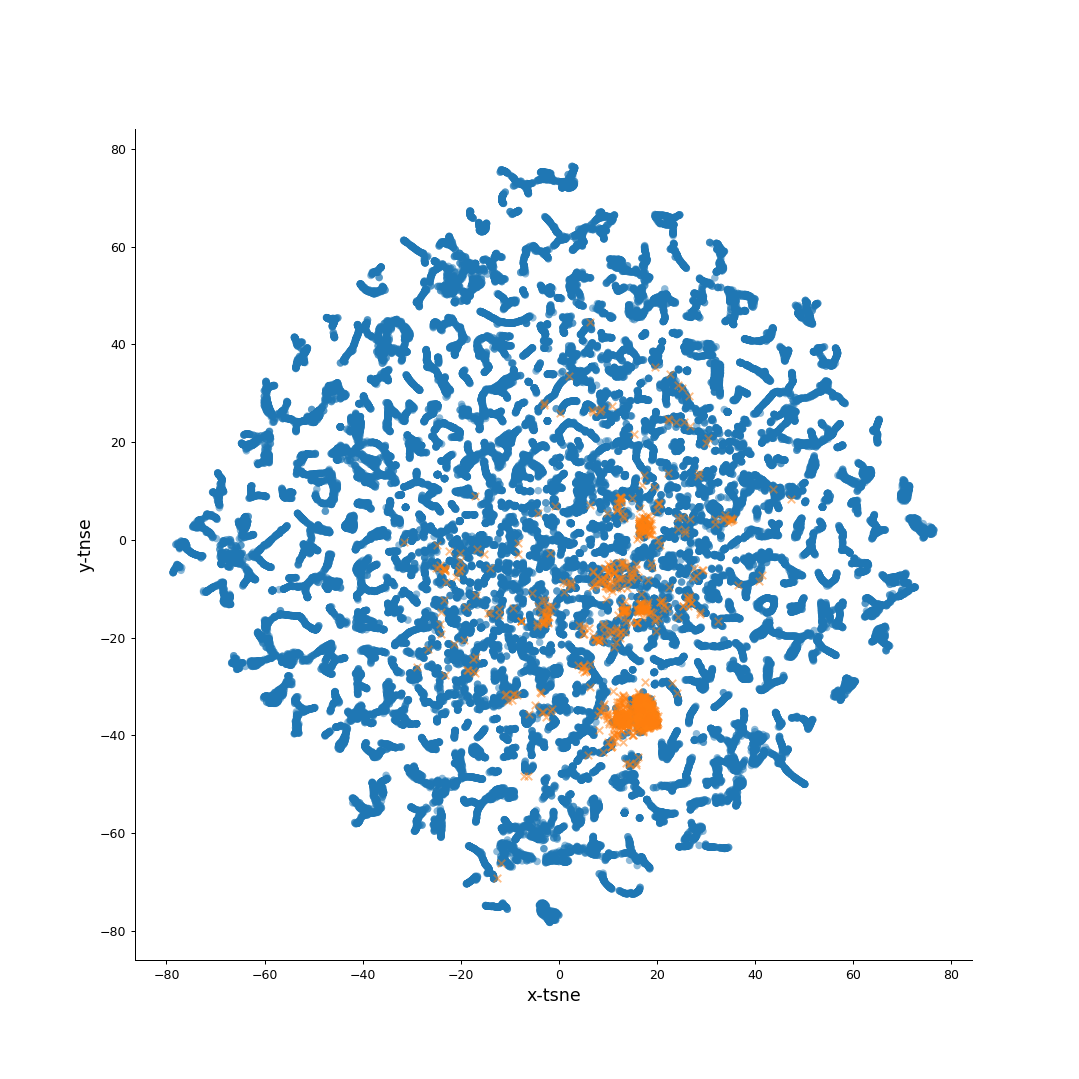

In [94]:
#%matplotlib notebook
plot_tsne_2d(cuda_tsne, labels)

In [85]:
sk_result =run_sk_tsne(pca_results, label)

(55160, 80)
Starting TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 55160 samples in 1.066s...
[t-SNE] Computed neighbors for 55160 samples in 1053.963s...
[t-SNE] Computed conditional probabilities for sample 1000 / 55160
[t-SNE] Computed conditional probabilities for sample 2000 / 55160
[t-SNE] Computed conditional probabilities for sample 3000 / 55160
[t-SNE] Computed conditional probabilities for sample 4000 / 55160
[t-SNE] Computed conditional probabilities for sample 5000 / 55160
[t-SNE] Computed conditional probabilities for sample 6000 / 55160
[t-SNE] Computed conditional probabilities for sample 7000 / 55160
[t-SNE] Computed conditional probabilities for sample 8000 / 55160
[t-SNE] Computed conditional probabilities for sample 9000 / 55160
[t-SNE] Computed conditional probabilities for sample 10000 / 55160
[t-SNE] Computed conditional probabilities for sample 11000 / 55160
[t-SNE] Computed conditional probabilities for sample 12000 / 55160
[t-SNE] Computed cond

[t-SNE] Iteration 2200: error = 0.9967468, gradient norm = 0.0000142 (50 iterations in 31.501s)
[t-SNE] Iteration 2250: error = 0.9938939, gradient norm = 0.0000142 (50 iterations in 30.965s)
[t-SNE] Iteration 2300: error = 0.9911584, gradient norm = 0.0000139 (50 iterations in 29.977s)
[t-SNE] Iteration 2350: error = 0.9884308, gradient norm = 0.0000135 (50 iterations in 30.925s)
[t-SNE] Iteration 2400: error = 0.9858313, gradient norm = 0.0000139 (50 iterations in 30.779s)
[t-SNE] Iteration 2450: error = 0.9832615, gradient norm = 0.0000142 (50 iterations in 30.057s)
[t-SNE] Iteration 2500: error = 0.9808869, gradient norm = 0.0000135 (50 iterations in 29.595s)
[t-SNE] Iteration 2550: error = 0.9787633, gradient norm = 0.0000130 (50 iterations in 30.076s)
[t-SNE] Iteration 2600: error = 0.9765210, gradient norm = 0.0000127 (50 iterations in 30.630s)
[t-SNE] Iteration 2650: error = 0.9741837, gradient norm = 0.0000122 (50 iterations in 31.304s)
[t-SNE] Iteration 2700: error = 0.971934

[t-SNE] Iteration 6500: error = 0.8803219, gradient norm = 0.0000088 (50 iterations in 27.712s)
[t-SNE] Iteration 6550: error = 0.8797267, gradient norm = 0.0000085 (50 iterations in 28.739s)
[t-SNE] Iteration 6600: error = 0.8792318, gradient norm = 0.0000084 (50 iterations in 29.227s)
[t-SNE] Iteration 6650: error = 0.8787210, gradient norm = 0.0000082 (50 iterations in 29.695s)
[t-SNE] Iteration 6700: error = 0.8780841, gradient norm = 0.0000085 (50 iterations in 29.741s)
[t-SNE] Iteration 6750: error = 0.8774107, gradient norm = 0.0000087 (50 iterations in 27.613s)
[t-SNE] Iteration 6800: error = 0.8766380, gradient norm = 0.0000090 (50 iterations in 28.444s)
[t-SNE] Iteration 6850: error = 0.8760375, gradient norm = 0.0000095 (50 iterations in 29.268s)
[t-SNE] Iteration 6900: error = 0.8753353, gradient norm = 0.0000093 (50 iterations in 32.226s)
[t-SNE] Iteration 6950: error = 0.8747488, gradient norm = 0.0000092 (50 iterations in 41.683s)
[t-SNE] Iteration 7000: error = 0.874328

<IPython.core.display.Javascript object>


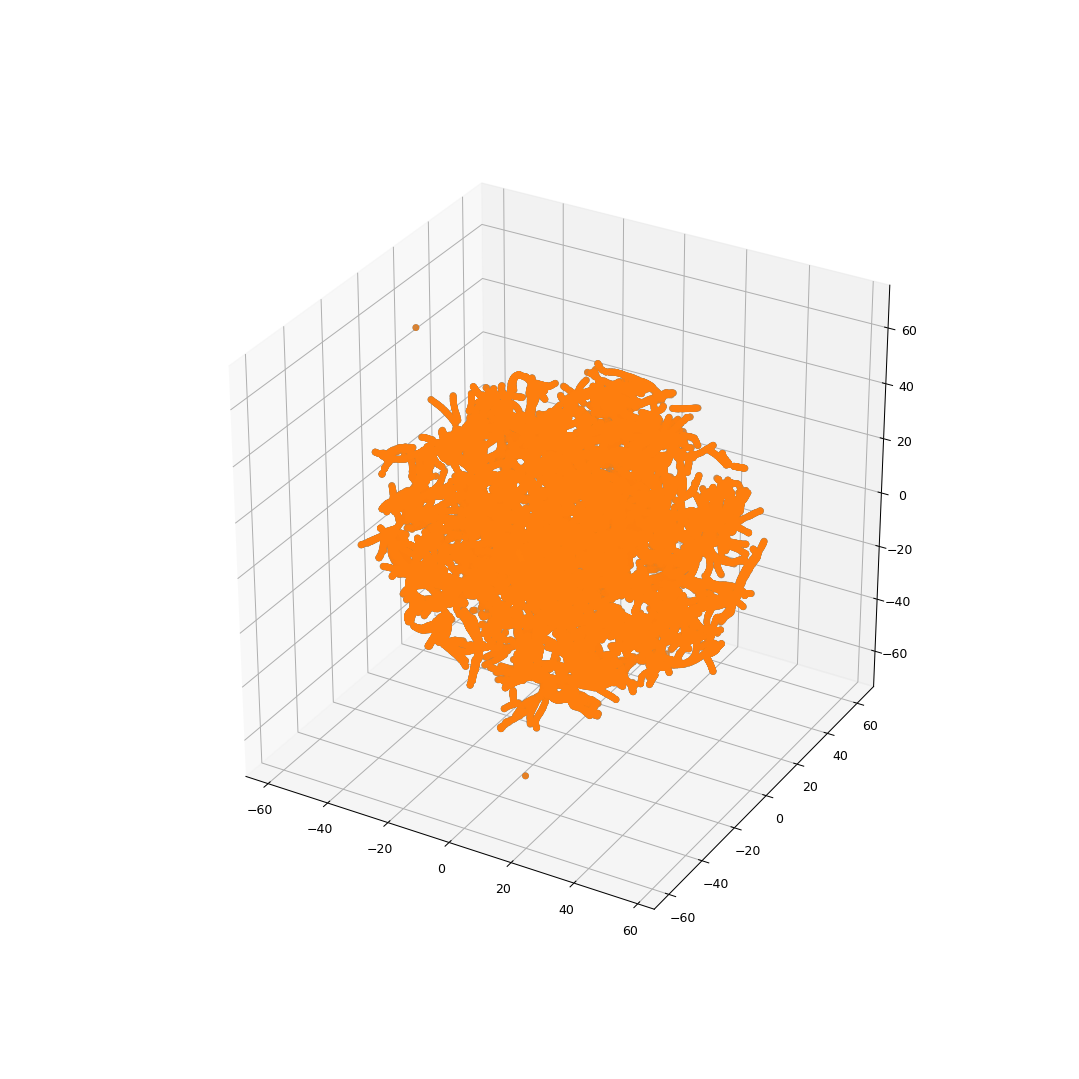

In [128]:
plot_tsne_3d(sk_result, labels)

In [130]:
print(sk_result.shape)
np.save('scikit_learn_tsne_3d_results', sk_result)

(55160, 3)
